In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-05-16 18:37:48.712336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 18:37:48.712365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
data1 = np.loadtxt("../data/UnionCom/scGEM/GeneExpression.txt")
data2 = np.loadtxt("../data/UnionCom/scGEM/DNAmethylation.txt")
type1 = np.loadtxt("../data/UnionCom/scGEM/type1.txt")
type2 = np.loadtxt("../data/UnionCom/scGEM/type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)

# Sampling
# idx = np.random.choice(range(data1.shape[0]), 50, replace=False)
# data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Labels
type_func = lambda x: {1:'BJ', 2:'d8', 3:'d16T+', 4:'d24T+', 5:'IPS'}[x]
labels = [np.array([type_func(j) for j in i]) for i in (type1,type2)]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [5]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 100
pca_dim = None

# ComManDo

In [6]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.9016 alpha:3.3532
epoch:[1000/2000] err:0.8065 alpha:3.4468
epoch:[1500/2000] err:0.7737 alpha:3.4895
epoch:[2000/2000] err:0.7415 alpha:3.5167
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.732068
epoch:[1000/2000]: loss:0.578440
epoch:[1500/2000]: loss:0.588848
epoch:[2000/2000]: loss:0.530894
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.02627824299997883
Correspondence: 1.8778207889999976
Mapping: 12.308974341999601
Total: 14.213073373999578

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.745311
epoch:[1000/2000]: loss:0.543557
epoch:[1500/2000]: loss:0.524461
epoch:[2000/2000

# Comparison Methods

In [7]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.9020 alpha:3.3540
epoch:[1000/2000] err:0.8068 alpha:3.4477
epoch:[1500/2000] err:0.7740 alpha:3.4904
epoch:[2000/2000] err:0.7421 alpha:3.5177
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:1.935589, align_loss:0.131565
epoch:[20/100]: loss:1.509872, align_loss:0.097724
epoch:[30/100]: loss:1.320364, align_loss:0.085334
epoch:[40/100]: loss:1.496087, align_loss:0.087746
epoch:[50/100]: loss:1.374307, align_loss:0.078140
epoch:[60/100]: loss:1.162812, align_loss:0.082964
epoch:[70/100]: loss:1.262273, align_loss:0.075555
epoch:[80/100]: loss:1.337930, align_loss:0.078837
epoch:[90/100]: loss:1.315040, align_loss:0.078224
epoch:[100/100]: loss:1.245573, align_loss:0.082542
Done
---------------------------------
ComManDo Done!
Dis

# Figure Generation

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:290: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= np.linalg.norm(y)
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:290: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= np.linalg.norm(y)


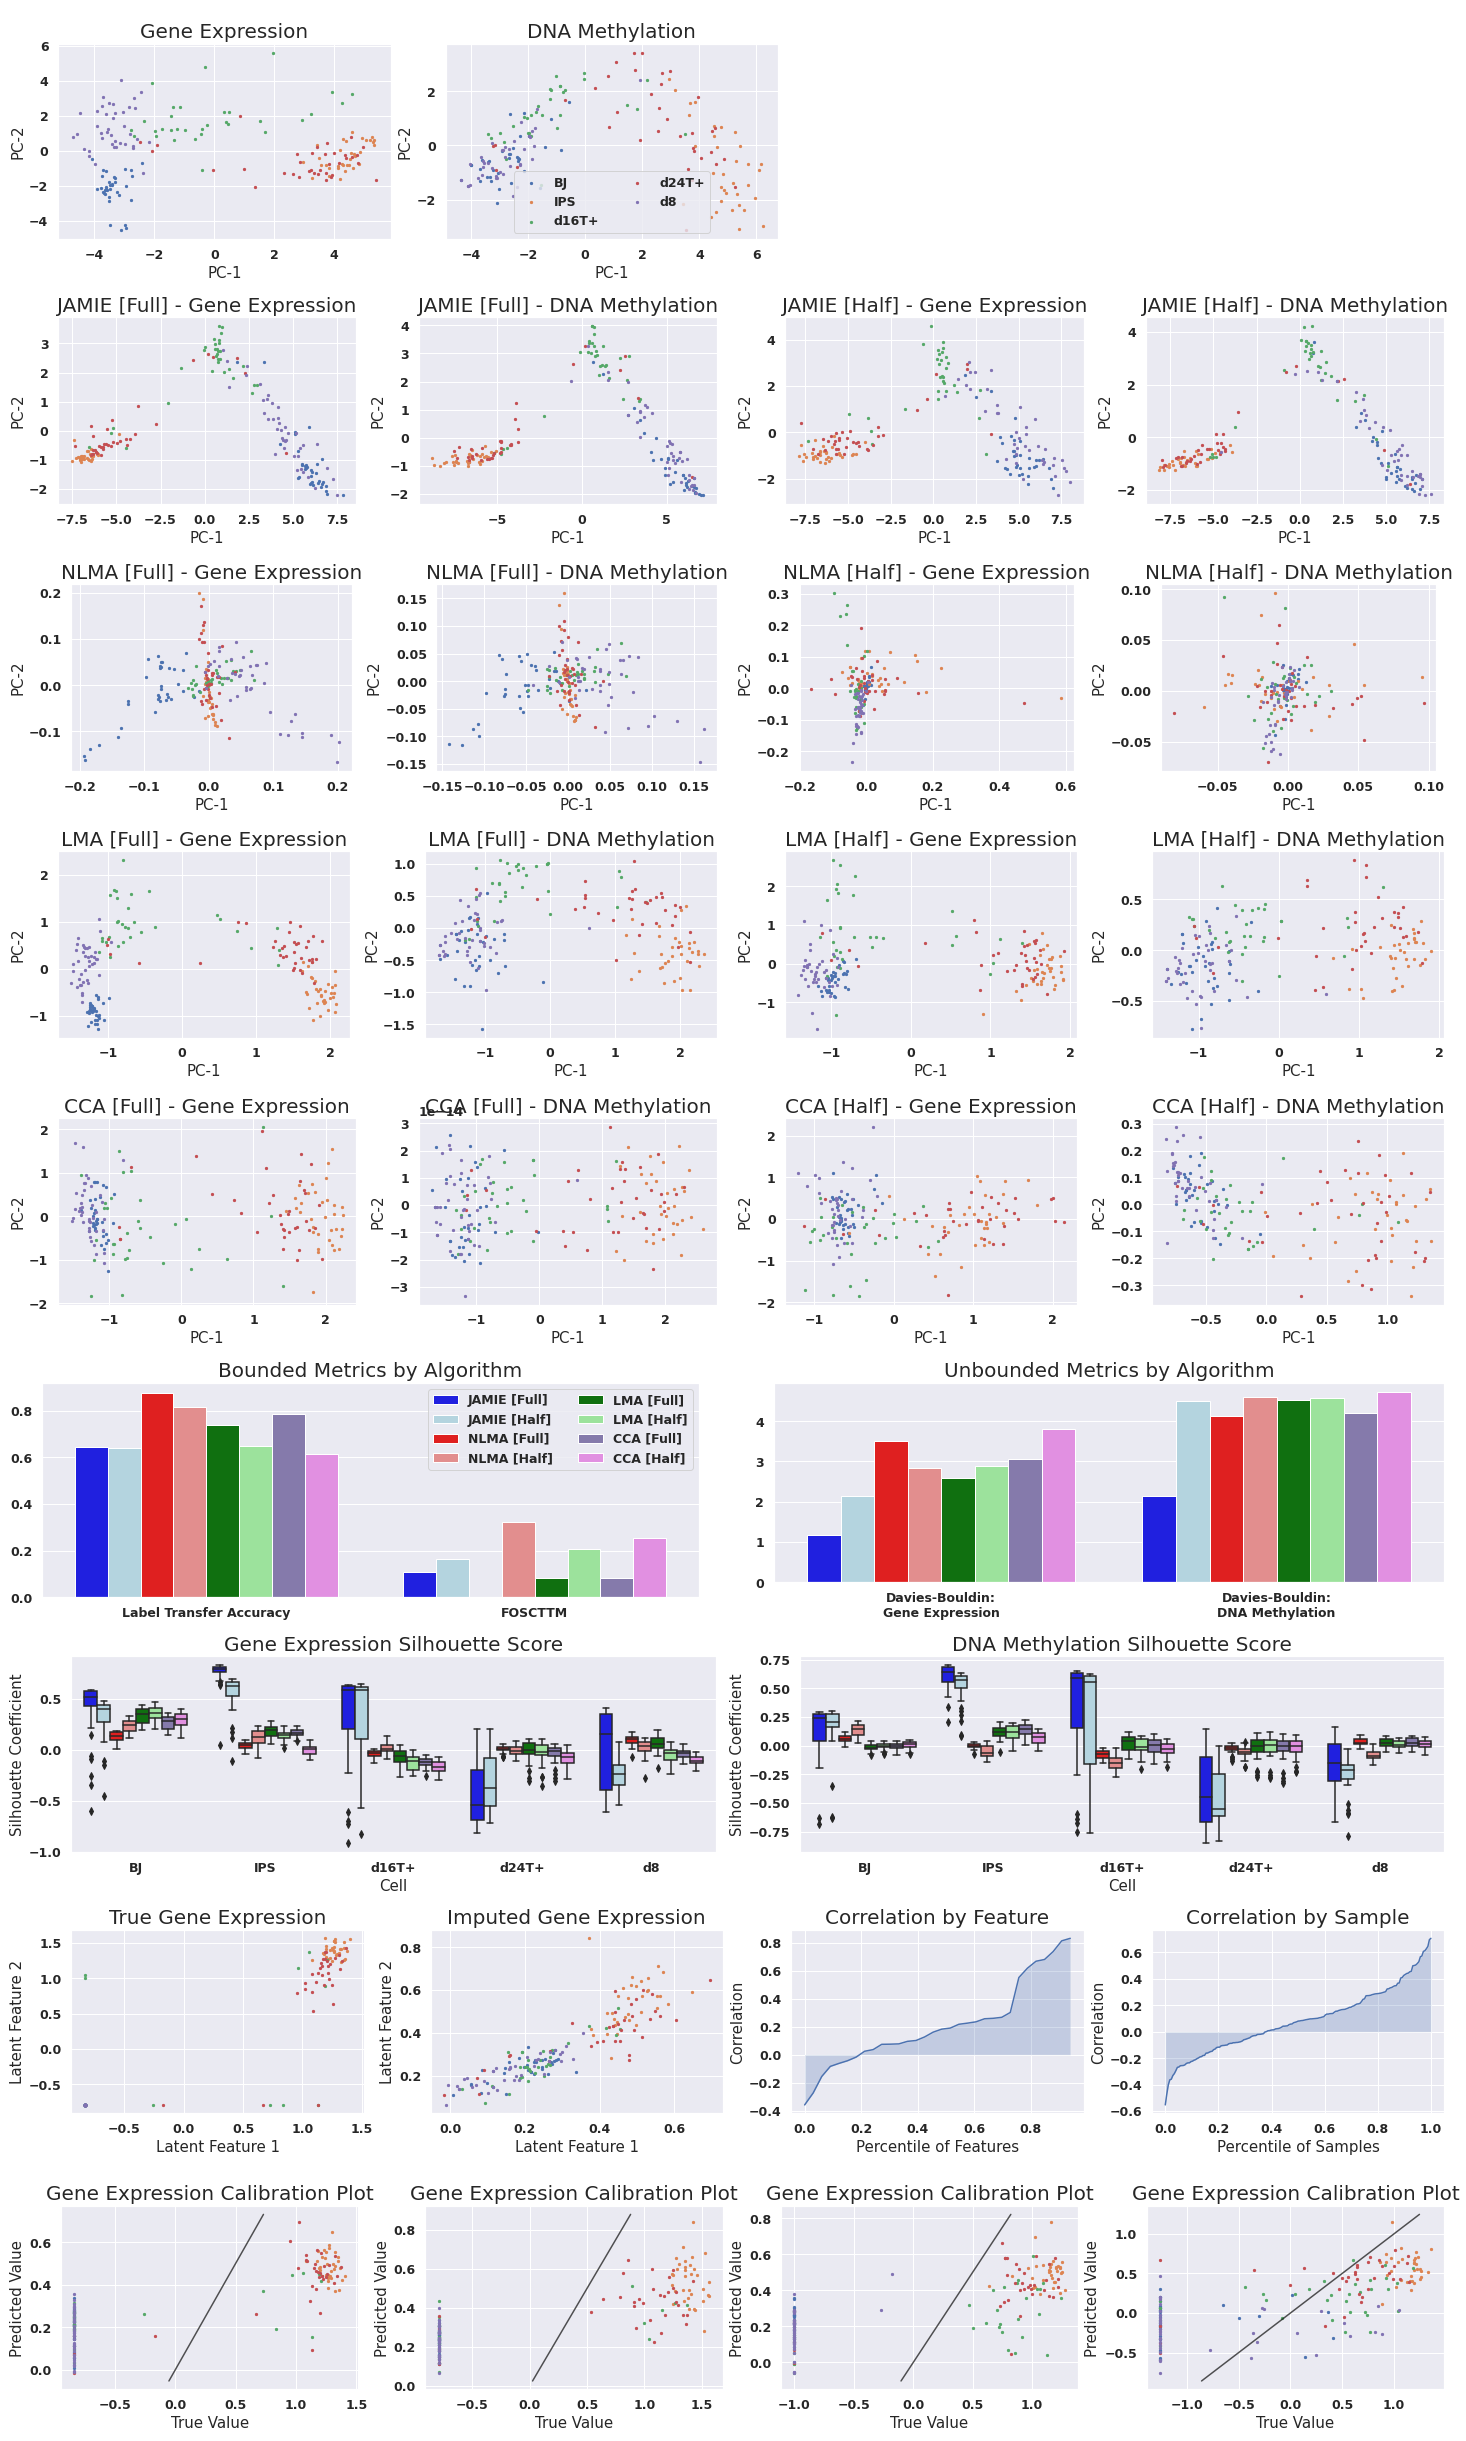

In [13]:
#%%capture --no-display
# https://miro.medium.com/max/800/1*zm6zVTIEvf9uZ0cE4n0Ogg.png
integrated_data = np.array([cm_data, cm_data_half, nlma_data, nlma_data_half, lma_data, lma_data_half, cca_data, cca_data_half])
integrated_alg_names = np.array(['JAMIE [Full]', 'JAMIE [Half]', 'NLMA [Full]', 'NLMA [Half]', 'LMA [Full]', 'LMA [Half]', 'CCA [Full]', 'CCA [Half]'])
colors = np.array(['blue', 'lightblue', 'red', 'lightcoral', 'green', 'lightgreen', 'm', 'violet'])
alg_groups = np.array([0, 1, 0, 1, 0, 1, 0, 1])
idx = range(len(integrated_data))  # [0,2,4,6,1,3,5,7]
params = {
    'dataset_names': ['Gene Expression', 'DNA Methylation'],
    'integrated_data': integrated_data[idx],
    'integrated_alg_names': integrated_alg_names[idx],
    'colors': colors[idx],
    'alg_groups': alg_groups[idx],
    'raw_data_group': 0,
    'scale': 20,
    'integrated_use_pca': True,
    'exclude_predict': [(0, 1)],
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params);